# Modeling the seasonal cycle of surface temperature

This notebook is part of [The Climate Laboratory](https://brian-rose.github.io/ClimateLaboratoryBook) by [Brian E. J. Rose](http://www.atmos.albany.edu/facstaff/brose/index.html), University at Albany.

____________
## 1. The observed seasonal cycle from NCEP Reanalysis data
____________



Look at the observed seasonal cycle in the NCEP reanalysis data.

Read in the necessary data from the online server *courtesy of the [NOAA Physical Sciences Laboratory](https://psl.noaa.gov)*

The catalog is here: <https://psl.noaa.gov/thredds/catalog/Datasets/ncep.reanalysis.derived/catalog.html>

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import climlab
from climlab import constants as const
import cartopy.crs as ccrs  # use cartopy to make some maps

In [2]:
ncep_url = "http://psl.noaa.gov/thredds/dodsC/Datasets/ncep.reanalysis.derived/"
ncep_Ts = xr.open_dataset(ncep_url + "surface_gauss/skt.sfc.mon.1981-2010.ltm.nc", decode_times=False)
# Alternative source from the University of Hawai'i
#url = "http://apdrc.soest.hawaii.edu:80/dods/public_data/Reanalysis_Data/NCEP/NCEP/clima/"
#ncep_Ts = xr.open_dataset(url + 'surface_gauss/skt')
lat_ncep = ncep_Ts.lat; lon_ncep = ncep_Ts.lon
Ts_ncep = ncep_Ts.skt
print( Ts_ncep.shape)

(12, 94, 192)


Make two maps: one of annual mean surface temperature, another of the seasonal range (max minus min).

In [3]:
maxTs = Ts_ncep.max(dim='time')
minTs = Ts_ncep.min(dim='time')
meanTs = Ts_ncep.mean(dim='time')

<>:6: SyntaxWarning: invalid escape sequence '\c'
<>:11: SyntaxWarning: invalid escape sequence '\c'
<>:6: SyntaxWarning: invalid escape sequence '\c'
<>:11: SyntaxWarning: invalid escape sequence '\c'
/var/folders/dl/j7hb106d36n501mrm8j646bxpf4y1c/T/ipykernel_74280/2156485626.py:6: SyntaxWarning: invalid escape sequence '\c'
  ax1.set_title('Annual mean surface temperature ($^\circ$C)', fontsize=14 )
/var/folders/dl/j7hb106d36n501mrm8j646bxpf4y1c/T/ipykernel_74280/2156485626.py:11: SyntaxWarning: invalid escape sequence '\c'
  ax2.set_title('Seasonal temperature range ($^\circ$C)', fontsize=14)


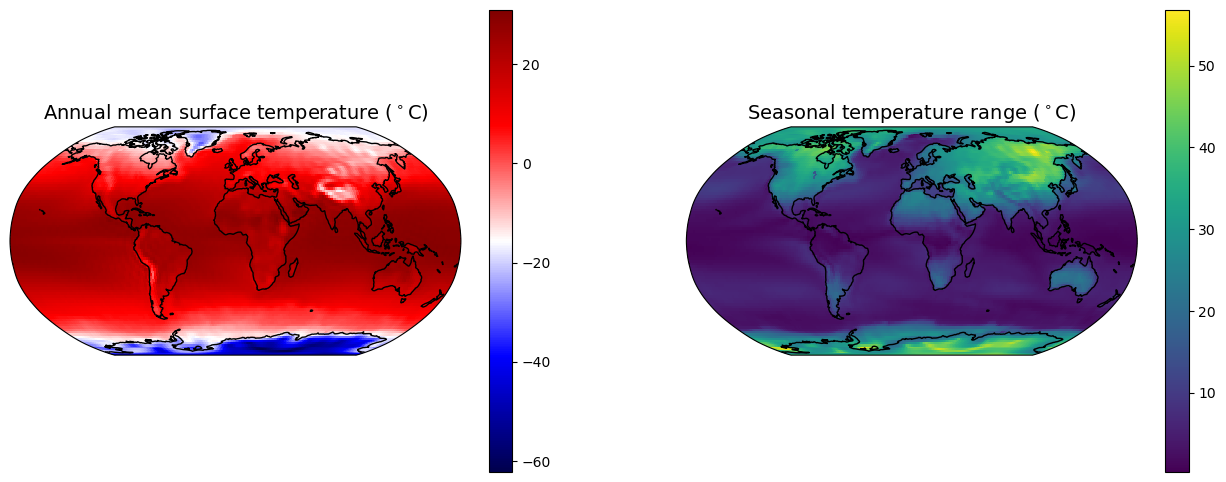

In [4]:
fig = plt.figure( figsize=(16,6) )

ax1 = fig.add_subplot(1,2,1, projection=ccrs.Robinson())
cax1 = ax1.pcolormesh(lon_ncep, lat_ncep, meanTs, cmap=plt.cm.seismic , transform=ccrs.PlateCarree())
cbar1 = plt.colorbar(cax1)
ax1.set_title('Annual mean surface temperature ($^\circ$C)', fontsize=14 )

ax2 = fig.add_subplot(1,2,2, projection=ccrs.Robinson())
cax2 = ax2.pcolormesh(lon_ncep, lat_ncep, maxTs - minTs, transform=ccrs.PlateCarree() )
cbar2 = plt.colorbar(cax2)
ax2.set_title('Seasonal temperature range ($^\circ$C)', fontsize=14)

for ax in [ax1,ax2]:
    #ax.contour( lon_cesm, lat_cesm, topo.variables['LANDFRAC'][:], [0.5], colors='k');
    #ax.set_xlabel('Longitude', fontsize=14 ); ax.set_ylabel('Latitude', fontsize=14 )
    ax.coastlines()

Make a contour plot of the zonal mean temperature as a function of time

Text(0.5, 1.0, 'Zonal mean surface temperature (degC)')

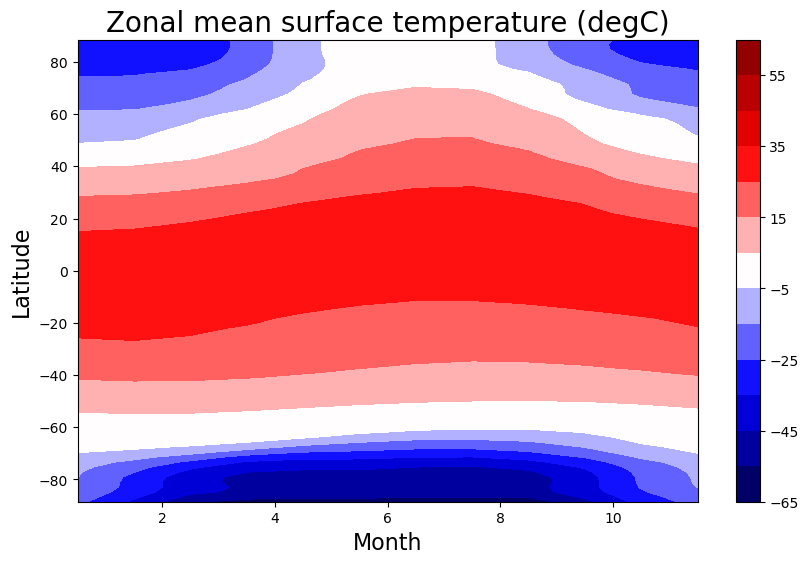

In [5]:
Tmax = 65; Tmin = -Tmax; delT = 10
clevels = np.arange(Tmin,Tmax+delT,delT)
fig_zonobs, ax = plt.subplots( figsize=(10,6) )
cax = ax.contourf(np.arange(12)+0.5, lat_ncep, 
                  Ts_ncep.mean(dim='lon').transpose(), levels=clevels, 
                  cmap=plt.cm.seismic, vmin=Tmin, vmax=Tmax)
ax.set_xlabel('Month', fontsize=16)
ax.set_ylabel('Latitude', fontsize=16 )
cbar = plt.colorbar(cax)
ax.set_title('Zonal mean surface temperature (degC)', fontsize=20)

____________
## 2. Analytical toy model of the seasonal cycle
____________


What factors determine the above pattern of seasonal temperatures? How large is the winter-to-summer variation in temperature? What is its phasing relative to the seasonal variations in insolation?

We will start to examine this in a very simple zero-dimensional EBM.

Suppose the seasonal cycle of insolation at a point is 

$$ Q = Q^* \sin\omega t + Q_0$$

where $\omega = 2\pi ~ \text{year}^{-1}$, $Q_0$ is the annual mean insolation, and $Q^*$ is the amplitude of the seasonal variations.

Here $\omega ~ t=0$ is spring equinox, $\omega~t = \pi/2$ is summer solstice, $\omega~t = \pi$ is fall equinox, and $ \omega ~t = 3 \pi/2$ is winter solstice.

Now suppose the temperature is governed by 

$$ C \frac{d T}{d t} = Q - (A + B~T) $$

so that we have a simple model

$$ C \frac{d T}{d t} = Q^* \sin\omega t + Q_0 - (A + B~T) $$

We want to ask two questions:

1. **What is the amplitude of the seasonal temperature variation?**
2. **When does the temperature maximum occur?**

We will look for an oscillating solution

$$  T(t) = T_0 + T^* \sin(\omega t - \Phi) $$

where $\Phi$ is an unknown phase shift and $T^*$ is the unknown amplitude of seasonal temperature variations.

### The annual mean:

Integrate over one year to find

$$ \overline{T} = T_0 $$

$$ Q_0 = A + B ~ \overline{T} $$

so that

$$T_0 = \frac{Q_0 - A}{B} $$

### The seasonal problem

Now we need to solve for $T^*$ and $\Phi$.

Take the derivative

$$  \frac{d T}{dt} = T^* \omega \cos(\omega t - \Phi) $$

and plug into the model equation to get

$$
\begin{align*}
C~ T^* \omega \cos(\omega t - \Phi) &=  Q^* \sin\omega t + Q_0  \\
                                    & - \left( A + B~(T_0 + T^* \sin(\omega t - \Phi) )\right)
\end{align*}
$$

Subtracting out the annual mean leaves us with

$$ C~ T^* \omega \cos(\omega t - \Phi) =  Q^* \sin\omega t  - B ~ T^* \sin(\omega t - \Phi)  $$

### Zero heat capacity: the radiative equilibrium solution

It's instructive to first look at the case with $C=0$, which means that the system is not capable of storing heat, and the temperature must always be in radiative equilibrium with the insolation.

In this case we would have

$$ Q^* \sin\omega t  = B ~ T^* \sin(\omega t - \Phi)  $$

which requires that the phase shift is

$$ \Phi = 0 $$

and the amplitude is

$$ T^* = \frac{Q^*}{B} $$

With no heat capacity, there can be no phase shift!  The temperature goes up and does in lockstep with the insolation. 
As we will see, the amplitude of the temperature variations is maximum in this limit.

As a practical example:  at 45ºN the amplitude of the seasonal insolation cycle is about 180 W m$^{-2}$  (see the [Insolation notes](./insolation.ipynb) -- the difference between insolation at summer and winter solstice is about 360 W m$^{-2}$ which we divide by two to get the amplitude of seasonal variations).

We will follow our previous EBM work and take $B = 2$ W m$^{-2}$ K$^{-1}$. This would give a seasonal temperature amplitude of 90ºC!

This highlights to important role for heat capacity to buffer the seasonal variations in sunlight.

### Non-dimensional heat capacity parameter

We can rearrange the seasonal equation to give

$$ \frac{C~\omega}{B} \cos(\omega t - \Phi) + \sin(\omega t - \Phi) = \frac{Q^*}{B~T^*} \sin\omega t   $$

The heat capacity appears in our equation through the non-dimensional ratio

$$ \tilde{C} = \frac{C~\omega}{B} $$

This parameter measures the efficiency of heat storage versus damping of energy anomalies through longwave radiation to space in our system.

We will now use trigonometric identities

$$
\begin{align*}
\cos(\omega t - \Phi) &= \cos\omega t \cos\Phi + \sin\omega t \sin\Phi  \\
\sin(\omega t - \Phi) &= \sin\omega t \cos\Phi - \cos\omega t \sin\Phi
\end{align*}
$$

to express our equation as

$$
\begin{align*}
\frac{Q^*}{B~T^*} \sin\omega t = &\tilde{C} \cos\omega t \cos\Phi \\
                                + &\tilde{C} \sin\omega t \sin\Phi \\
                                + &\sin\omega t \cos\Phi  \\
                                - &\cos\omega t \sin\Phi
\end{align*}
$$

Now gathering together all terms in $\cos\omega t$ and $\sin\omega t$:

$$ \cos\omega t \left( \tilde{C} \cos\Phi - \sin\Phi \right) = \sin\omega t \left( \frac{Q^*}{B~T^*} - \tilde{C} \sin\Phi - \cos\Phi \right) $$

### Solving for the phase shift

The equation above must be true for all $t$, which means that sum of terms in each set of parentheses must be zero.

We therefore have an equation for the phase shift

$$ \tilde{C} \cos\Phi - \sin\Phi = 0 $$

which means that the phase shift is

$$ \Phi = \arctan \tilde{C} $$

### Solving for the amplitude

The other equation is 

$$ \frac{Q^*}{B~T^*} - \tilde{C} \sin\Phi - \cos\Phi = 0 $$

or

$$ \frac{Q^*}{B~T^*} - \cos\Phi \left( 1+ \tilde{C}^2 \right)  = 0 $$

which we solve for $T^*$ to get

$$ T^* = \frac{Q^*}{B} \frac{1}{\left( 1+ \tilde{C}^2 \right) \cos\left(\arctan \tilde{C} \right) } $$

### Shallow water limit:

In low heat capacity limit,

$$ \tilde{C} << 1 $$

the phase shift is

$$ \Phi \approx \tilde{C} $$

and the amplitude is

$$ T^* = \frac{Q^*}{B} \left( 1 - \tilde{C} \right) $$

Notice that for a system with very little heat capacity, the **phase shift approaches zero** and the **amplitude approaches its maximum value** $T^* = \frac{Q^*}{B}$.

In the shallow water limit the temperature maximum will occur just slightly after the insolation maximum, and the seasonal temperature variations will be large.

### Deep water limit:

Suppose instead we have an infinitely large heat reservoir (e.g. very deep ocean mixed layer).

In the limit $\tilde{C} \rightarrow \infty$, the phase shift tends toward

$$ \Phi \rightarrow \frac{\pi}{2} $$

so the warming is nearly perfectly out of phase with the insolation -- peak temperature would occur at fall equinox.

But the amplitude in this limit is very small!

$$ T^* \rightarrow 0 $$

### What values of $\tilde{C}$ are realistic?

We need to evaluate 

$$ \tilde{C} = \frac{C~\omega}{B} $$

for reasonable values of $C$ and $B$.

$B$ is the longwave radiative feedback in our system: a measure of how efficiently a warm anomaly is radiated away to space. We have previously chosen $B = 2$ W m$^{-2}$ K$^{-1}$.

$C$ is the heat capacity of the whole column, a number in J m$^{-2}$ K$^{-1}$.


#### Heat capacity of the atmosphere

Integrating from the surface to the top of the atmosphere, we can write

$$ C_a = \int_0^{p_s} c_p \frac{dp}{g} $$

where $c_p = 10^3$ J kg$^{-1}$ K$^{-1}$ is the specific heat at constant pressure for a unit mass of air, and $dp/g$ is a mass element.

This gives $C_a \approx 10^7$ J m$^{-2}$ K$^{-1}$.

#### Heat capacity of a water surface

As we wrote [back in the notes on Modeling the Global Energy Budget](./zero-dim-ebm.ipynb), the heat capacity for a well-mixed column of water is

$$C_w = c_w \rho_w H_w $$

where 

$c_w = 4 \times 10^3$ J kg$^{-1}$ $^\circ$C$^{-1}$ is the specific heat of water,

$\rho_w = 10^3$ kg m$^{-3}$ is the density of water, and

$H_w $ is the depth of the water column

**The heat capacity of the entire atmosphere is thus equivalent to 2.5 meters of water.**

#### $\tilde{C}$ for a dry land surface

A dry land surface has very little heat capacity and $C$ is actually dominated by the atmosphere. So we can take $C = C_a = 10^7$ J m$^{-2}$ K$^{-1}$ as a reasonable lower bound.

So our lower bound on $\tilde{C}$ is thus, taking $B = 2$ W m$^{-2}$ K$^{-1}$ and $\omega = 2\pi ~ \text{year}^{-1} = 2 \times 10^{-7} \text{ s}^{-1}$:

$$ \tilde{C} = 1 $$

#### $\tilde{C}$ for a 100 meter ocean mixed layer

Setting $H_w = 100$ m gives $C_w = 4 \times 10^8$ J m$^{-2}$ K$^{-1}$. Then our non-dimensional parameter is

$$ \tilde{C} = 40 $$ 

### The upshot: $\tilde{C}$ is closer to the deep water limit

Even for a dry land surface, $\tilde{C}$ is not small. This means that there is always going to be a substantial phase shift in the timing of the peak temperatures, and a reduction in the seasonal amplitude.

### Plot the full solution for a range of water depths

In [6]:
omega = 2*np.pi / const.seconds_per_year
omega

1.991063797294792e-07

In [7]:
B = 2.
Hw = np.linspace(0., 100.)
Ctilde = const.cw * const.rho_w * Hw * omega / B
amp = 1./((Ctilde**2+1)*np.cos(np.arctan(Ctilde)))
Phi = np.arctan(Ctilde)

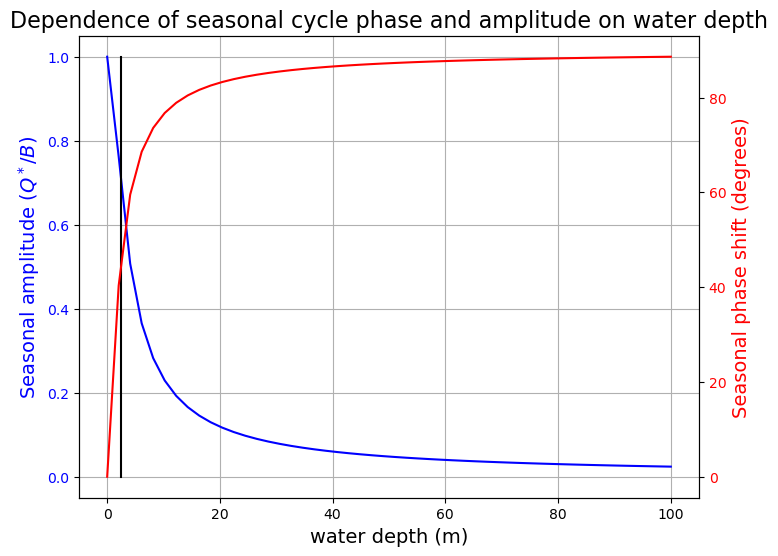

In [8]:
color1 = 'b'
color2 = 'r'

fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(111)
ax1.plot(Hw, amp, color=color1)
ax1.set_xlabel('water depth (m)', fontsize=14)
ax1.set_ylabel('Seasonal amplitude ($Q^* / B$)', fontsize=14,  color=color1)
for tl in ax1.get_yticklabels():
    tl.set_color(color1)
ax2 = ax1.twinx()
ax2.plot(Hw, np.rad2deg(Phi), color=color2)
ax2.set_ylabel('Seasonal phase shift (degrees)', fontsize=14, color=color2)
for tl in ax2.get_yticklabels():
    tl.set_color(color2)
ax1.set_title('Dependence of seasonal cycle phase and amplitude on water depth', fontsize=16)
ax1.grid()

ax1.plot([2.5, 2.5], [0, 1], 'k-');

The blue line shows the amplitude of the seasonal cycle of temperature, expressed as a fraction of its maximum value $\frac{Q^*}{B}$ (the value that would occur if the system had zero heat capacity so that temperatures were always in radiative equilibrium with the instantaneous insolation).

The red line shows the phase lag (in degrees) of the temperature cycle relative to the insolation cycle.

The vertical black line indicates 2.5 meters of water, which is the heat capacity of the atmosphere and thus our effective lower bound on total column heat capacity.

### The seasonal phase shift

Even for the driest surfaces the phase shift is about 45º and the amplitude is half of its theoretical maximum. For most wet surfaces the cycle is damped out and delayed further.

Of course we are already familiar with this phase shift from our day-to-day experience. Our calendar says that summer "begins" at the solstice and last until the equinox. 

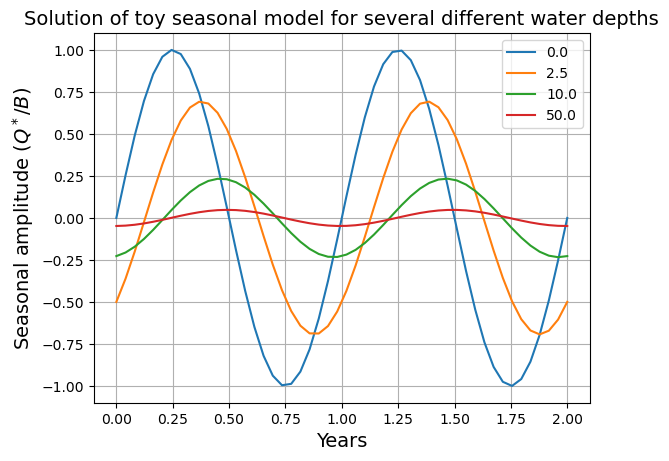

In [9]:
fig, ax = plt.subplots()
years = np.linspace(0,2)
Harray = np.array([0., 2.5, 10., 50.])
for Hw in Harray:
    Ctilde = const.cw * const.rho_w * Hw * omega / B
    Phi = np.arctan(Ctilde)
    ax.plot(years, np.sin(2*np.pi*years - Phi)/np.cos(Phi)/(1+Ctilde**2), label=Hw)
ax.set_xlabel('Years', fontsize=14)
ax.set_ylabel('Seasonal amplitude ($Q^* / B$)', fontsize=14)
ax.set_title('Solution of toy seasonal model for several different water depths', fontsize=14)
ax.legend(); ax.grid()

The blue curve in this figure is in phase with the insolation.

____________
## 3. Exploring the amplitude of the seasonal cycle with an EBM
____________


Something important is missing from this toy model: heat transport!

The amplitude of the seasonal cycle of insolation increases toward the poles, but the seasonal temperature variations are partly mitigated by heat transport from lower, warmer latitudes.

Our 1D diffusive EBM is the appropriate tool for exploring this further.

We are looking at the 1D (zonally averaged) energy balance model with diffusive heat transport. The equation is


$$ C \frac{\partial T_s}{\partial t} = (1-\alpha) ~ Q - \left( A + B~T_s \right) + \frac{D}{\cos⁡\phi } \frac{\partial }{\partial \phi} \left(   \cos⁡\phi  ~ \frac{\partial T_s}{\partial \phi} \right) $$

with the albedo given by

$$ \alpha(\phi) = \alpha_0 + \alpha_2 P_2(\sin\phi) $$



and we will use
```
climlab.EBM_seasonal
``` 
to solve this model numerically.

One handy feature of `climlab` process code: the function `integrate_years()` automatically calculates the time averaged temperature. So if we run it for exactly one year, we get the annual mean temperature (and many other diagnostics) saved in the dictionary `timeave`.

We will look at the seasonal cycle of temperature in three different models with different heat capacities (which we express through an equivalent depth of water in meters). 

All other parameters will be [as chosen in the notes on the one-dimensional energy balance model](./one-dim-ebm.ipynb) (which focussed on tuning the EBM to the annual mean energy budget).

In [10]:
#  for convenience, set up a dictionary with our reference parameters
param = {'A':210, 'B':2, 'a0':0.354, 'a2':0.25, 'D':0.6}
param

{'A': 210, 'B': 2, 'a0': 0.354, 'a2': 0.25, 'D': 0.6}

In [11]:
#  We can pass the entire dictionary as keyword arguments using the ** notation
model1 = climlab.EBM_seasonal(**param, name='Seasonal EBM')
model1

Notice that this model has an insolation subprocess called `DailyInsolation`, rather than `AnnualMeanInsolation`. These should be fairly self-explanatory.

In [12]:
#  We will try three different water depths
water_depths = np.array([2., 10., 50.])

num_depths = water_depths.size
Tann = np.empty( [model1.lat.size, num_depths] )
models = []

for n in range(num_depths):
    ebm = climlab.EBM_seasonal(water_depth=water_depths[n], **param)
    models.append(ebm)
    models[n].integrate_years(20., verbose=False )
    models[n].integrate_years(1., verbose=False)
    Tann[:,n] = np.squeeze(models[n].timeave['Ts'])

All models should have the same annual mean temperature:

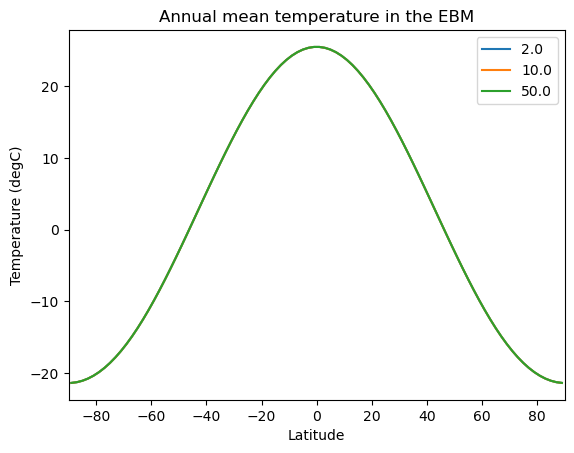

In [13]:
lat = model1.lat
fig, ax = plt.subplots()
ax.plot(lat, Tann)
ax.set_xlim(-90,90)
ax.set_xlabel('Latitude')
ax.set_ylabel('Temperature (degC)')
ax.set_title('Annual mean temperature in the EBM')
ax.legend( water_depths )

There is no automatic function in the `climlab` code to keep track of minimum and maximum temperatures (though we might add that in the future!)

Instead we'll step through one year "by hand" and save all the temperatures.

In [14]:
num_steps_per_year = int(model1.time['num_steps_per_year'])
Tyear = np.empty((lat.size, num_steps_per_year, num_depths))
for n in range(num_depths):
    for m in range(num_steps_per_year):
        models[n].step_forward()
        Tyear[:,m,n] = np.squeeze(models[n].Ts)

Make a figure to compare the observed zonal mean seasonal temperature cycle to what we get from the EBM with different heat capacities:

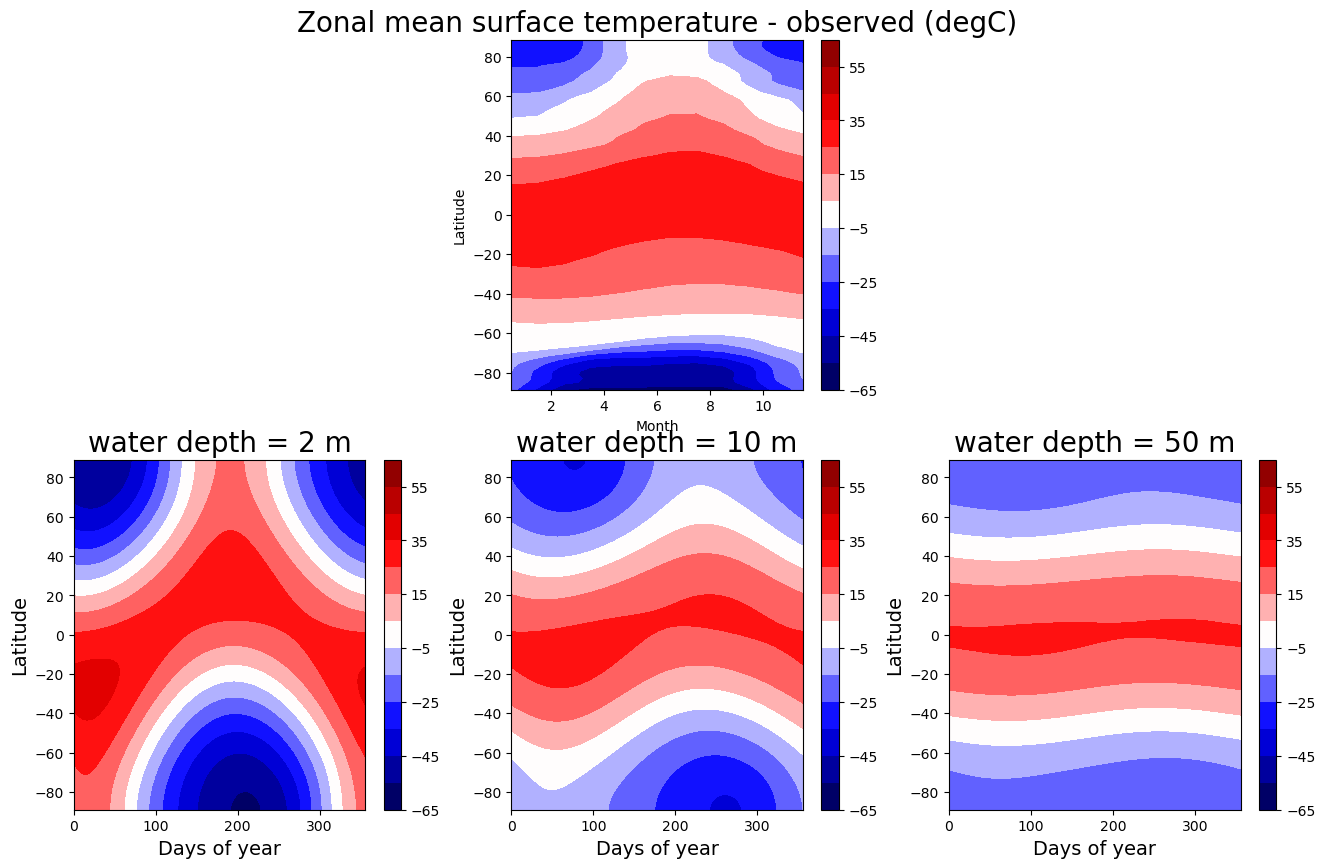

In [15]:
fig = plt.figure( figsize=(16,10) )

ax = fig.add_subplot(2,num_depths,2)
cax = ax.contourf(np.arange(12)+0.5, lat_ncep, 
                  Ts_ncep.mean(dim='lon').transpose(), 
                  levels=clevels, cmap=plt.cm.seismic, 
                  vmin=Tmin, vmax=Tmax)
ax.set_xlabel('Month')
ax.set_ylabel('Latitude')
cbar = plt.colorbar(cax)
ax.set_title('Zonal mean surface temperature - observed (degC)', fontsize=20)

for n in range(num_depths):
    ax = fig.add_subplot(2,num_depths,num_depths+n+1)
    cax = ax.contourf(4*np.arange(num_steps_per_year),
                      lat, Tyear[:,:,n], levels=clevels, 
                      cmap=plt.cm.seismic, vmin=Tmin, vmax=Tmax)
    cbar1 = plt.colorbar(cax)
    ax.set_title('water depth = %.0f m' %models[n].param['water_depth'], fontsize=20 )
    ax.set_xlabel('Days of year', fontsize=14 )
    ax.set_ylabel('Latitude', fontsize=14 )

Which one looks more realistic? Depends a bit on where you look. But overall, the observed seasonal cycle matches the 10 meter case best. The effective heat capacity governing the seasonal cycle of the zonal mean temperature is closer to 10 meters of water than to either 2 or 50 meters.

### Making an animation of the EBM solutions

Let's animate the seasonal cycle of insolation and temperature in our models with the three different water depths

In [16]:
def initial_figure(models):
    fig, axes = plt.subplots(1,len(models), figsize=(15,4))
    lines = []
    for n in range(len(models)):
        ax = axes[n]
        c1 = 'b'
        Tsline = ax.plot(lat, models[n].Ts, c1)[0]
        ax.set_title('water depth = %.0f m' %models[n].param['water_depth'], fontsize=20 )
        ax.set_xlabel('Latitude', fontsize=14 )
        if n == 0:
            ax.set_ylabel('Temperature', fontsize=14, color=c1 )
        ax.set_xlim([-90,90])
        ax.set_ylim([-60,60])
        for tl in ax.get_yticklabels():
            tl.set_color(c1)
        ax.grid()

        c2 = 'r'
        ax2 = ax.twinx()
        Qline = ax2.plot(lat, models[n].insolation, c2)[0]
        if n == 2:
            ax2.set_ylabel('Insolation (W m$^{-2}$)', color=c2, fontsize=14)
        for tl in ax2.get_yticklabels():
            tl.set_color(c2)
        ax2.set_xlim([-90,90])
        ax2.set_ylim([0,600])
        lines.append([Tsline, Qline])
    return fig, axes, lines

In [17]:
def animate(step, models, lines):
    for n, ebm in enumerate(models):
        ebm.step_forward()
        #  The rest of this is just updating the plot
        lines[n][0].set_ydata(ebm.Ts)
        lines[n][1].set_ydata(ebm.insolation)
    return lines

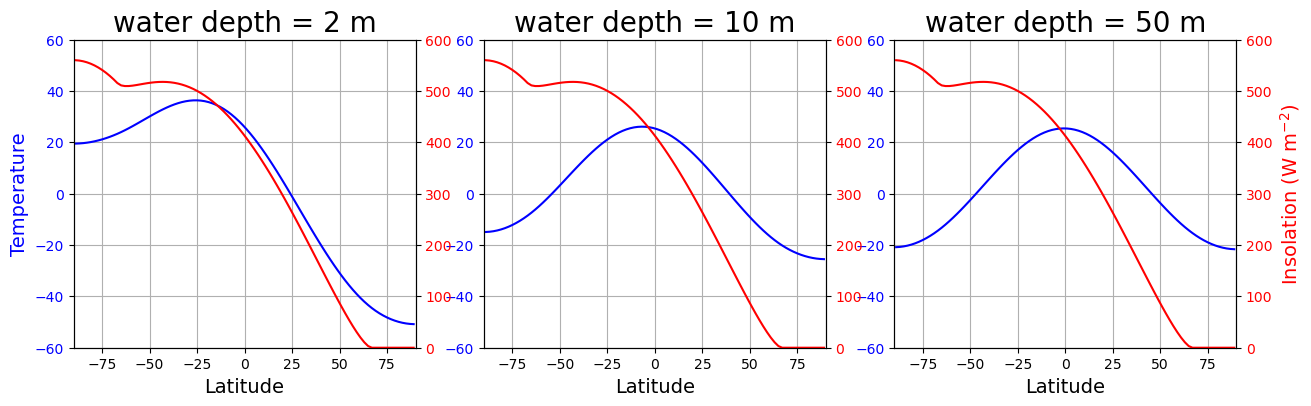

In [18]:
#  Plot initial data
fig, axes, lines = initial_figure(models)

In [19]:
#  Some imports needed to make and display animations
from IPython.display import HTML
from matplotlib import animation

num_steps = int(models[0].time['num_steps_per_year'])
ani = animation.FuncAnimation(fig, animate, 
        frames=num_steps,
        interval=80,
        fargs=(models, lines),
        )

In [20]:
HTML(ani.to_html5_video())

____________
## 4. The seasonal cycle for a planet with 90º obliquity
____________


The EBM code uses our familiar `insolation.py` code to calculate insolation, and therefore it's easy to set up a model with different orbital parameters. Here is an example with **very** different orbital parameters: 90º obliquity. We looked at the distribution of insolation by latitude and season for this type of planet in the last homework.

In [21]:
orb_highobl = {'ecc':0., 
               'obliquity':90., 
               'long_peri':0.}
print( orb_highobl)
model_highobl = climlab.EBM_seasonal(orb=orb_highobl, **param)
print( model_highobl.param['orb'])

{'ecc': 0.0, 'obliquity': 90.0, 'long_peri': 0.0}
{'ecc': 0.0, 'obliquity': 90.0, 'long_peri': 0.0}


Repeat the same procedure to calculate and store temperature throughout one year, after letting the models run out to equilibrium.

In [22]:
Tann_highobl = np.empty( [lat.size, num_depths] )
models_highobl = []

for n in range(num_depths):
    model = climlab.EBM_seasonal(water_depth=water_depths[n], 
                                 orb=orb_highobl, 
                                 **param)
    models_highobl.append(model)
    models_highobl[n].integrate_years(40., verbose=False )
    models_highobl[n].integrate_years(1., verbose=False)
    Tann_highobl[:,n] = np.squeeze(models_highobl[n].timeave['Ts'])

Tyear_highobl = np.empty([lat.size, num_steps_per_year, num_depths])
for n in range(num_depths):
    for m in range(num_steps_per_year):
        models_highobl[n].step_forward()
        Tyear_highobl[:,m,n] = np.squeeze(models_highobl[n].Ts)

And plot the seasonal temperature cycle same as we did above:

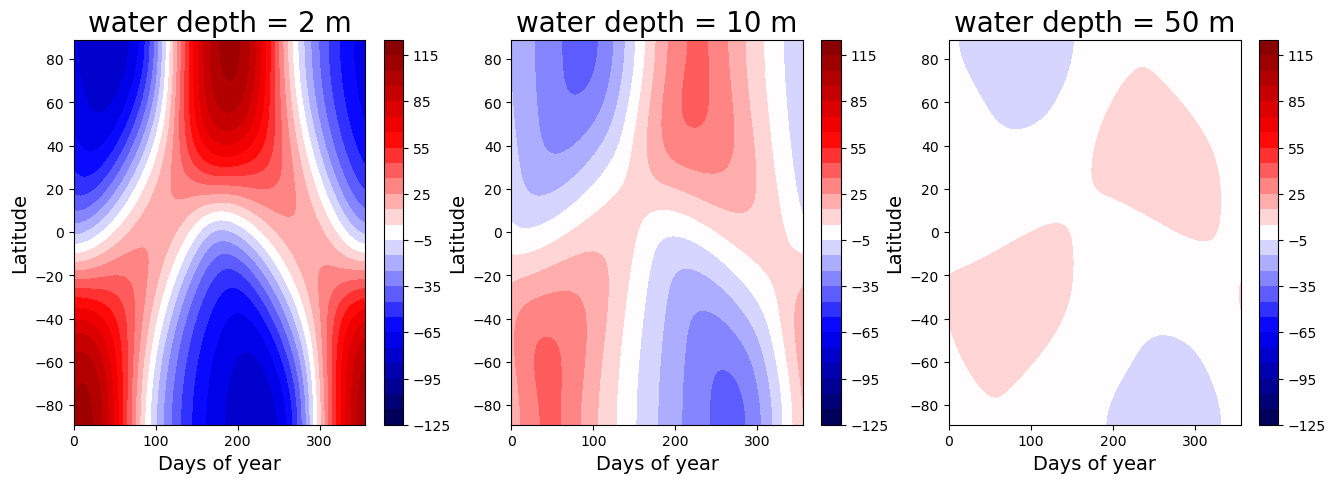

In [23]:
fig = plt.figure( figsize=(16,5) )
Tmax_highobl = 125; Tmin_highobl = -Tmax_highobl; delT_highobl = 10
clevels_highobl = np.arange(Tmin_highobl, Tmax_highobl+delT_highobl, delT_highobl)
for n in range(num_depths):
    ax = fig.add_subplot(1,num_depths,n+1)
    cax = ax.contourf( 4*np.arange(num_steps_per_year), lat, Tyear_highobl[:,:,n], 
        levels=clevels_highobl, cmap=plt.cm.seismic, vmin=Tmin_highobl, vmax=Tmax_highobl )
    cbar1 = plt.colorbar(cax)
    ax.set_title('water depth = %.0f m' %models[n].param['water_depth'], fontsize=20 )
    ax.set_xlabel('Days of year', fontsize=14 )
    ax.set_ylabel('Latitude', fontsize=14 )

Note that the temperature range is much larger than for the Earth-like case above (but same contour interval, 10 degC).

Why is the temperature so uniform in the north-south direction with 50 meters of water?

To see the reason, let's plot the annual mean insolation at 90º obliquity, alongside the present-day annual mean insolation:

In [24]:
lat2 = np.linspace(-90, 90, 181)
days = np.linspace(1.,50.)/50 * const.days_per_year
Q_present = climlab.solar.insolation.daily_insolation( lat2, days )
Q_highobl = climlab.solar.insolation.daily_insolation( lat2, days, orb_highobl )
Q_present_ann = np.mean( Q_present, axis=1 )
Q_highobl_ann = np.mean( Q_highobl, axis=1 )

Text(0.5, 1.0, 'Annual mean insolation for two different obliquities')

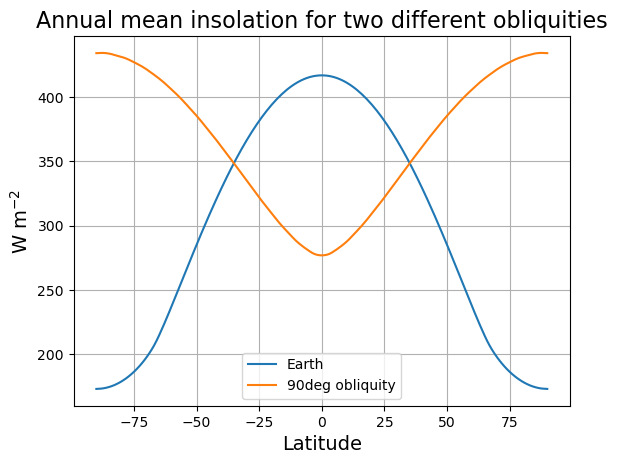

In [25]:
fig, ax = plt.subplots()
ax.plot( lat2, Q_present_ann, label='Earth' )
ax.plot( lat2, Q_highobl_ann, label='90deg obliquity' )
ax.grid()
ax.legend(loc='lower center')
ax.set_xlabel('Latitude', fontsize=14 )
ax.set_ylabel('W m$^{-2}$', fontsize=14 )
ax.set_title('Annual mean insolation for two different obliquities', fontsize=16)

Though this is a bit misleading, because our model prescribes an increase in albedo from the equator to the pole. So the absorbed shortwave gradients look even more different.

If you are interested in how ice-albedo feedback might work on a high-obliquity planet with a cold equator, then I suggest you take a look at this paper {cite:p}`Rose:2017a`:

[Rose, Cronin and Bitz (2017): Ice Caps and Ice Belts: The Effects of Obliquity on Ice−Albedo Feedback, The Astrophysical Journal 846, doi:10.3847/1538-4357/aa8306](https://iopscience.iop.org/article/10.3847/1538-4357/aa8306/meta)

____________

## Credits

This notebook is part of [The Climate Laboratory](https://brian-rose.github.io/ClimateLaboratoryBook), an open-source textbook developed and maintained by [Brian E. J. Rose](http://www.atmos.albany.edu/facstaff/brose/index.html), University at Albany.

It is licensed for free and open consumption under the
[Creative Commons Attribution 4.0 International (CC BY 4.0)](https://creativecommons.org/licenses/by/4.0/) license.

Development of these notes and the [climlab software](https://github.com/climlab/climlab) is partially supported by the National Science Foundation under award AGS-1455071 to Brian Rose. Any opinions, findings, conclusions or recommendations expressed here are mine and do not necessarily reflect the views of the National Science Foundation.
____________